# Random Forest

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load and preprocess the data
submission = pd.read_csv('Submission_Files/submission_format.csv')
test_set_feat = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')
train_set_feat = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')
train_set_lab = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')

In [3]:
# Join train_set_feat and train_set_lab by 'respondent_id' column
train_data = train_set_feat.join(train_set_lab)

# Display the joined dataframe
train_data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [4]:
# View Proportion of Missing Data (Descending)
train_data.isna().sum().sort_values(ascending=False)/len(train_data)

employment_occupation          0.504362
employment_industry            0.499120
health_insurance               0.459580
income_poverty                 0.165612
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
rent_or_own                    0.076459
employment_status              0.054780
marital_status                 0.052720
education                      0.052683
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
opinion_seas_sick_from_vacc    0.020107
opinion_seas_risk              0.019246
opinion_seas_vacc_effective    0.017299
opinion_h1n1_sick_from_vacc    0.014790
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
household_adults               0.009323
household_children             0.009323
behavioral_avoidance           0.007788
behavioral_touch_face          0.004793
h1n1_knowledge                 0.004343
h1n1_concern                   0.003445


## Identify the categorical features that require one-hot encoding or rank order

#### Binary
- 'sex'
- 'marital_status'
- 'rent_or_own'

#### Rank Order
- 'age_group'
- 'education'
- 'income_poverty'
- 'employment_status'
- 'census_msa'

#### One Hot Encoding (Dummies)
- 'race'
- 'hhs_geo_region'
- 'employment_industry'
- 'employment_occupation'

In [6]:
# Create a function to encode dataset

def data_encoding(data):
    # Replace Binary Categories with 0 and 1
    data['sex'] = data['sex'].replace({'Male': 0, 'Female': 1})
    data['marital_status'] = data['marital_status'].replace({'Not Married': 0, 'Married': 1})
    data['rent_or_own'] = data['rent_or_own'].replace({'Rent': 0, 'Own': 1})

    # Replace Rank Order Categories starting with 0 to number of categories resepctively
    data['age_group'] = data['age_group'].replace({'18 - 34 Years': 0,
                                                               '35 - 44 Years': 1,
                                                               '45 - 54 Years': 2,
                                                               '55 - 64 Years': 3,
                                                               '65+ Years': 4
    })

    data['education'] = data['education'].replace({'< 12 Years': 0,
                                                               '12 Years': 1,
                                                               'Some College': 2,
                                                               'College Graduate': 3
    })

    data['income_poverty'] = data['income_poverty'].replace({'Below Poverty': 0,
                                                                         '<= $75,000, Above Poverty': 1,
                                                                         '> $75,000': 2
    })

    data['employment_status'] = data['employment_status'].replace({'Not in Labor Force': 0, 
                                                                               'Unemployed': 1,
                                                                               'Employed': 2
    })

    data['census_msa'] = data['census_msa'].replace({'Non-MSA': 0,
                                                                 'MSA, Not Principle  City': 1,
                                                                 'MSA, Principle City': 2
    })

    # One Hot Encode categories that do not have rank order
    #from sklearn.preprocessing import OneHotEncoder

    # Define the columns to be one hot encoded
    columns_to_encode = ['race', 'hhs_geo_region', 'employment_industry', 'employment_occupation']

    # Create an instance of the OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Fit and transform the selected columns
    encoded_columns = encoder.fit_transform(data[columns_to_encode])

    # Create a dataframe with the encoded columns
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names(columns_to_encode))

    # Set index back to DataFrame
    encoded_df.index = data.index
    
    # Concatenate the encoded dataframe with the original dataframe
    data_encoded = pd.concat([data, encoded_df], axis=1)
    
    # Drop the original columns that were encoded
    data_encoded.drop(columns_to_encode, axis=1, inplace=True)
    
    return data_encoded

In [7]:
# Use function
train_data_encoded = data_encoding(train_data)

train_data_encoded

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,race_Black,race_Hispanic,race_Other or Multiple,race_White,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,...,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_industry_nan,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,employment_occupation_nan
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,3,0.0,1,0.0,0.0,1.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,1,1.0,0,0.0,0.0,0.0,2.0,1,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,0,3.0,0,1.0,0.0,1.0,2.0,1,2.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,4,1.0,1,0.0,0.0,0.0,0.0,2,0.0,0.0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,2,2.0,1,1.0,1.0,1.0,2.0,1,1.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,

## One Hot Encode columns with missing values for Random Forest

In [8]:
# One Hot Encode columns with missing values
train_data_reencoded = pd.get_dummies(train_data_encoded, columns=train_data_encoded.columns[train_data_encoded.isna().any()], dummy_na=True)

train_data_reencoded.shape

(26707, 178)

In [39]:
# Drop columns with "_nan" and rename dataframe
train_data_reencoded2 = train_data_reencoded.drop(columns=[col for col in train_data_reencoded.columns if "_nan" in col])

In [41]:
# Check column names
for i in train_data_reencoded2.columns:
    print(i)
    
train_data_reencoded2.shape

age_group
sex
census_msa
h1n1_vaccine
seasonal_vaccine
race_Black
race_Hispanic
race_Other or Multiple
race_White
hhs_geo_region_atmpeygn
hhs_geo_region_bhuqouqj
hhs_geo_region_dqpwygqj
hhs_geo_region_fpwskwrf
hhs_geo_region_kbazzjca
hhs_geo_region_lrircsnp
hhs_geo_region_lzgpxyit
hhs_geo_region_mlyzmhmf
hhs_geo_region_oxchjgsf
hhs_geo_region_qufhixun
employment_industry_arjwrbjb
employment_industry_atmlpfrs
employment_industry_cfqqtusy
employment_industry_dotnnunm
employment_industry_fcxhlnwr
employment_industry_haxffmxo
employment_industry_ldnlellj
employment_industry_mcubkhph
employment_industry_mfikgejo
employment_industry_msuufmds
employment_industry_nduyfdeo
employment_industry_phxvnwax
employment_industry_pxcmvdjn
employment_industry_qnlwzans
employment_industry_rucpziij
employment_industry_saaquncn
employment_industry_vjjrobsf
employment_industry_wlfvacwt
employment_industry_wxleyezf
employment_industry_xicduogh
employment_industry_xqicxuve
employment_occupation_bxpfxfdn
employ

(26707, 148)

## Train/Validate H1N1 Vax with RandomForest

In [9]:
# Split Data into Train/Test (75%/25%)
X = train_data_reencoded.drop(columns=['h1n1_vaccine','seasonal_vaccine'], axis=1)
y = train_data_reencoded[['h1n1_vaccine']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [10]:
# Create RF Model for H1N1 

rf = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = {'max_depth': [4,5,6], 
              #'min_samples_leaf': [0.25,0.5,0.75],
              #'min_samples_split': [0.25,0.5,0.75],
              'max_features': [0.10,0.15,0.2,'sqrt'],
              'max_samples': [0.25,0.50],
              'class_weight': ['balanced_subsample'],
              'n_estimators': [200]
             } 

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [11]:
%%time

# Instantiate GridSearchCV object
rf_h1n1_gscv = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc')

# Fit the data to the RF model
rf_h1n1_gscv.fit(X_train, y_train)

CPU times: user 24.8 s, sys: 4.34 s, total: 29.1 s
Wall time: 33.6 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [4, 5, 6],
                         'max_features': [0.1, 0.15, 0.2, 'sqrt'],
                         'max_samples': [0.25, 0.5], 'n_estimators': [200]},
             scoring='roc_auc')

In [12]:
# Best hyperparameters for RF (H1N1)
print(rf_h1n1_gscv.best_estimator_)
print(rf_h1n1_gscv.best_params_)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.15, max_samples=0.5, n_estimators=200,
                       n_jobs=-1, random_state=1)
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 200}


### Best Features
{'max_depth': 4, 'max_features': 0.25, 'max_samples': 0.25, 'min_samples_leaf': 0.25, 'min_samples_split': 0.25, 'n_estimators': 200}

{'max_depth': 6, 'max_features': 0.25, 'n_estimators': 1000}

{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'n_estimators': 1000}

{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 1000}


In [13]:
# Predict probabilities for the TRAIN set
y_pred_proba_train_h1n1 = rf_h1n1_gscv.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_h1n1 = rf_h1n1_gscv.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_h1n1 = rf_h1n1_gscv.predict(X_test)

In [14]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

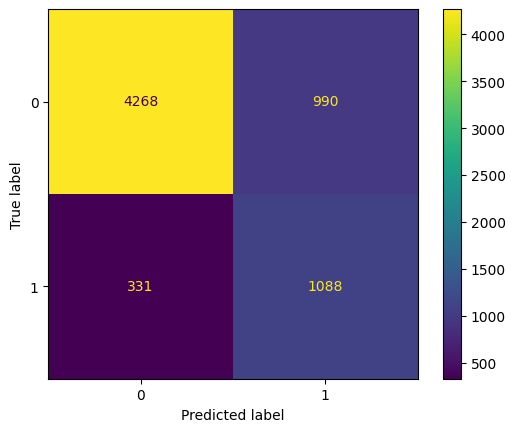

In [15]:
# Display Confusion Matrix
conf_matrix_plot(rf_h1n1_gscv, X_test, y_test)

In [16]:
# Classification Report (H1N1)
print(classification_report(y_test, y_preds_test_h1n1))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      5258
           1       0.52      0.77      0.62      1419

    accuracy                           0.80      6677
   macro avg       0.73      0.79      0.74      6677
weighted avg       0.84      0.80      0.81      6677



In [30]:
# Calculate ROC AUC score for RF
roc_auc_train_RF_h1n1 = roc_auc_score(y_train, y_pred_proba_train_h1n1[:,1])
roc_auc_test_RF_h1n1 = roc_auc_score(y_test, y_pred_proba_test_h1n1[:,1])

# Print ROC AUC scores
print(f'AUROC RF H1n1 Train: {roc_auc_train_RF_h1n1}'
      f'\nAUROC RF H1n1 Test: {roc_auc_test_RF_h1n1}'
)

AUROC RF H1n1 Train: 0.8658714256184111
AUROC RF H1n1 Test: 0.8640498414309307


In [18]:
# Function to draw ROC curve and print score

def draw_roc_curve(test, pred_proba):
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(test, pred_proba)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    return roc_auc_score(test, pred_proba)

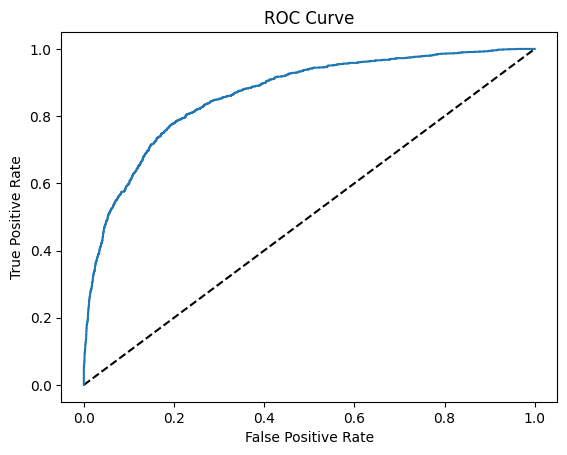

0.8640498414309307

In [19]:
# H1N1 Test
draw_roc_curve(y_test, y_pred_proba_test_h1n1[:,1])

### Looks good so far as hyperparameters are good for H1N1. Try Seasonal

## Create base model for seasonal (se) vax

In [20]:
# Split Data into Train/Test (75%/25%)
X_se = train_data_reencoded.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y_se = train_data_reencoded[['seasonal_vaccine']]

X_train_se, X_test_se, y_train_se, y_test_se = train_test_split(X_se, y_se, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1)

In [21]:
%%time

# Instantiate GridSearchCV object
rf_se_gscv = GridSearchCV(rf, param_grid, cv=skf, scoring='roc_auc')

# Fit the data to the RF model
rf_se_gscv.fit(X_train_se, y_train_se)

CPU times: user 24.7 s, sys: 3.84 s, total: 28.6 s
Wall time: 33.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             param_grid={'class_weight': ['balanced_subsample'],
                         'max_depth': [4, 5, 6],
                         'max_features': [0.1, 0.15, 0.2, 'sqrt'],
                         'max_samples': [0.25, 0.5], 'n_estimators': [200]},
             scoring='roc_auc')

In [22]:
# Best hyperparameters for RF (Seasonal)
print(rf_se_gscv.best_estimator_)
print(rf_se_gscv.best_params_)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       max_features=0.15, max_samples=0.5, n_estimators=200,
                       n_jobs=-1, random_state=1)
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 200}


## Best Hyperparameters
{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.1, 'n_estimators': 1000}

{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.2, 'max_samples': 0.25, 'n_estimators': 1000}

{'class_weight': 'balanced_subsample', 'max_depth': 6, 'max_features': 0.15, 'max_samples': 0.5, 'n_estimators': 200}

In [23]:
# Predict probabilities for the TRAIN set
y_pred_proba_train_se = rf_se_gscv.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se = rf_se_gscv.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se = rf_se_gscv.predict(X_test_se)

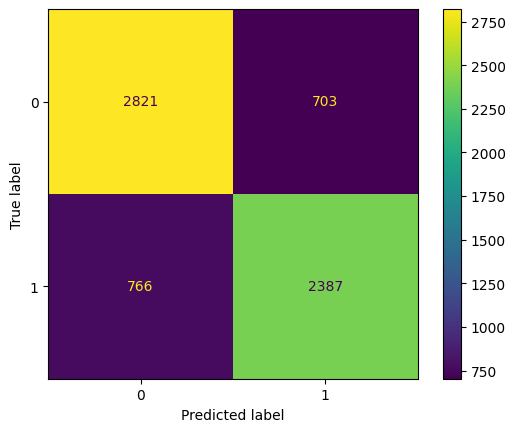

In [24]:
# Display Confusion Matrix
conf_matrix_plot(rf_se_gscv, X_test_se, y_test_se)

In [25]:
# Classification Report (Seasonal)
print(classification_report(y_test_se, y_preds_test_se))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      3524
           1       0.77      0.76      0.76      3153

    accuracy                           0.78      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



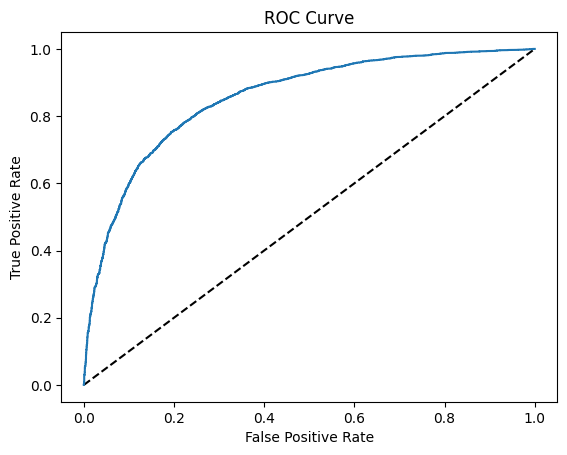

0.8545566570295194

In [26]:
# Seasonal Test
draw_roc_curve(y_test_se, y_pred_proba_test_se[:,1])

In [29]:
# Calculate ROC AUC score for RF
roc_auc_train_RF_se = roc_auc_score(y_train_se, y_pred_proba_train_se[:,1])
roc_auc_test_RF_se = roc_auc_score(y_test_se, y_pred_proba_test_se[:,1])

# Print ROC AUC scores
print(f'AUROC RF Seasonal Train: {roc_auc_train_RF_se}'
      f'\nAUROC RF Seasonal Test: {roc_auc_test_RF_se}'
)

AUROC RF Seasonal Train: 0.8513534525487501
AUROC RF Seasonal Test: 0.8545566570295194


## Bayesian Optimization via Optuna

In [31]:
!pip install optuna

import optuna
import optuna.visualization as vis


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 39.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Optuna with H1N1

In [55]:
# Step 1: Define the objective function for Optuna to minimize
def objective_h1n1(trial):
    # Define the hyperparameters to tune
    params = {
        'class_weight': 'balanced_subsample',
        'max_depth': trial.suggest_int('max_depth', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'max_samples': trial.suggest_uniform('max_samples', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }
    
    # Train an RF model with the current hyperparameters
    model = RandomForestClassifier(**params, random_state=1)
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set and return the score
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [56]:
%%time
# Step 2: Create an Optuna study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_h1n1, n_trials=200)

[I 2023-07-24 05:09:02,028] A new study created in memory with name: no-name-a5a95c3b-bbf2-4771-bd41-5ae128b7a145
[I 2023-07-24 05:09:02,583] Trial 0 finished with value: 0.8537807819809996 and parameters: {'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 7, 'max_features': 'sqrt', 'max_samples': 0.4838544900787959, 'n_estimators': 79}. Best is trial 0 with value: 0.8537807819809996.
[I 2023-07-24 05:09:04,448] Trial 1 finished with value: 0.8580796777741411 and parameters: {'max_depth': 8, 'min_samples_leaf': 49, 'min_samples_split': 77, 'max_features': 'log2', 'max_samples': 0.9184639260573008, 'n_estimators': 161}. Best is trial 1 with value: 0.8580796777741411.
[I 2023-07-24 05:09:05,023] Trial 2 finished with value: 0.8557761306573747 and parameters: {'max_depth': 8, 'min_samples_leaf': 42, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.7355731249670793, 'n_estimators': 55}. Best is trial 1 with value: 0.8580796777741411.
[I 2023-07-24 05:09:05,816] T

In [57]:
# Convert study into DataFrame

study_h1n1_df = study.trials_dataframe()

study_h1n1_df.sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_max_samples,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
71,71,0.869852,2023-07-24 05:11:27.680152,2023-07-24 05:11:29.898119,0 days 00:00:02.217967,10,sqrt,0.622680,4,8,151,COMPLETE
181,181,0.869703,2023-07-24 05:15:25.639575,2023-07-24 05:15:27.997102,0 days 00:00:02.357527,10,sqrt,0.688561,3,18,151,COMPLETE
65,65,0.869589,2023-07-24 05:11:15.761621,2023-07-24 05:11:18.016566,0 days 00:00:02.254945,10,sqrt,0.616142,4,7,152,COMPLETE
180,180,0.869333,2023-07-24 05:15:23.299271,2023-07-24 05:15:25.638195,0 days 00:00:02.338924,10,sqrt,0.691950,1,18,149,COMPLETE
182,182,0.869329,2023-07-24 05:15:27.998558,2023-07-24 05:15:30.313948,0 days 00:00:02.315390,10,sqrt,0.691323,1,19,148,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,0.853224,2023-07-24 05:12:14.307972,2023-07-24 05:12:15.683683,0 days 00:00:01.375711,3,sqrt,0.635240,11,23,173,COMPLETE
15,15,0.853104,2023-07-24 05:09:17.279797,2023-07-24 05:09:18.038472,0 days 00:00:00.758675,5,log2,0.833622,48,85,81,COMPLETE
85,85,0.846387,2023-07-24 05:11:58.019016,2023-07-24 05:11:58.997160,0 days 00:00:00.978144,2,sqrt,0.531465,7,2,153,COMPLETE
3,3,0.843764,2023-07-24 05:09:05.024788,2023-07-24 05:09:05.815767,0 days 00:00:00.790979,2,auto,0.205527,16,78,177,COMPLETE


In [58]:
# Step 3: Print the best hyperparameters and score found by Optuna
print(f'Best score: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.86985
Best parameters:
    max_depth: 10
    min_samples_leaf: 4
    min_samples_split: 8
    max_features: sqrt
    max_samples: 0.6226797136100981
    n_estimators: 151


In [59]:
# Plot parameter importance
vis.plot_param_importances(study)

## Optuna with Seasonal

In [60]:
# Step 1: Define the objective function for Optuna to minimize
def objective_se(trial):
    # Define the hyperparameters to tune
    params = {
        'class_weight': 'balanced_subsample',
        'max_depth': trial.suggest_int('max_depth', 2, 10), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'max_samples': trial.suggest_uniform('max_samples', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
    }
    
    # Train an RF model with the current hyperparameters
    model = RandomForestClassifier(**params, random_state=1, n_jobs=-1)
    model.fit(X_train_se, y_train_se)
    
    # Evaluate the model on the validation set and return the score
    y_pred_proba = model.predict_proba(X_test_se)[:, 1]
    return roc_auc_score(y_test_se, y_pred_proba)

In [61]:
%%time
# Step 2: Create an Optuna study object and optimize the objective function
study_se = optuna.create_study(direction='maximize')
study_se.optimize(objective_se, n_trials=200)

[I 2023-07-24 05:25:20,050] A new study created in memory with name: no-name-d32b7b40-b2c6-4a4a-8d03-e76d496de28a
[I 2023-07-24 05:25:20,304] Trial 0 finished with value: 0.8428173913606953 and parameters: {'max_depth': 8, 'min_samples_leaf': 81, 'min_samples_split': 87, 'max_features': 'log2', 'max_samples': 0.1631337719617517, 'n_estimators': 75}. Best is trial 0 with value: 0.8428173913606953.
[I 2023-07-24 05:25:20,645] Trial 1 finished with value: 0.8302270903555448 and parameters: {'max_depth': 6, 'min_samples_leaf': 52, 'min_samples_split': 29, 'max_features': 'sqrt', 'max_samples': 0.027938101259704758, 'n_estimators': 116}. Best is trial 0 with value: 0.8428173913606953.
[I 2023-07-24 05:25:21,447] Trial 2 finished with value: 0.8533806334741285 and parameters: {'max_depth': 9, 'min_samples_leaf': 37, 'min_samples_split': 65, 'max_features': 'log2', 'max_samples': 0.650392364678346, 'n_estimators': 196}. Best is trial 2 with value: 0.8533806334741285.
[I 2023-07-24 05:25:21,81

CPU times: user 8min 36s, sys: 29.9 s, total: 9min 6s
Wall time: 2min 14s


In [62]:
# Convert study into DataFrame

study_se_df = study_se.trials_dataframe()

study_se_df.sort_values(by='value', ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_max_features,params_max_samples,params_min_samples_leaf,params_min_samples_split,params_n_estimators,state
94,94,0.863379,2023-07-24 05:26:19.765363,2023-07-24 05:26:20.477237,0 days 00:00:00.711874,10,auto,0.767597,1,32,136,COMPLETE
184,184,0.863278,2023-07-24 05:27:23.087212,2023-07-24 05:27:23.872688,0 days 00:00:00.785476,10,auto,0.764035,1,8,153,COMPLETE
199,199,0.863167,2023-07-24 05:27:33.973479,2023-07-24 05:27:34.769910,0 days 00:00:00.796431,10,auto,0.730626,1,2,152,COMPLETE
186,186,0.863057,2023-07-24 05:27:24.205861,2023-07-24 05:27:24.985319,0 days 00:00:00.779458,10,auto,0.761946,4,9,152,COMPLETE
155,155,0.863013,2023-07-24 05:27:02.067985,2023-07-24 05:27:02.785758,0 days 00:00:00.717773,10,auto,0.686248,1,23,151,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...
18,18,0.842508,2023-07-24 05:25:28.968302,2023-07-24 05:25:29.264663,0 days 00:00:00.296361,3,auto,0.775565,10,84,61,COMPLETE
104,104,0.841869,2023-07-24 05:26:27.101144,2023-07-24 05:26:27.798711,0 days 00:00:00.697567,3,sqrt,0.758907,3,43,165,COMPLETE
10,10,0.836221,2023-07-24 05:25:24.913197,2023-07-24 05:25:25.185718,0 days 00:00:00.272521,2,auto,0.961996,7,100,54,COMPLETE
59,59,0.833527,2023-07-24 05:25:52.918385,2023-07-24 05:25:53.584891,0 days 00:00:00.666506,2,auto,0.820506,29,17,153,COMPLETE


In [63]:
# Step 3: Print the best hyperparameters and score found by Optuna
print(f'Best score: {study_se.best_value:.5f}')
print('Best parameters:')
for key, value in study_se.best_params.items():
    print(f'    {key}: {value}')

Best score: 0.86338
Best parameters:
    max_depth: 10
    min_samples_leaf: 1
    min_samples_split: 32
    max_features: auto
    max_samples: 0.7675965669381748
    n_estimators: 136


In [64]:
# Plot parameter importance
vis.plot_param_importances(study_se)

#### H1N1
- Best score: 0.86985
- Best parameters:
    - max_depth: 10
    - min_samples_leaf: 4
    - min_samples_split: 8
    - max_features: sqrt
    - max_samples: 0.6226797136100981
    - n_estimators: 151

#### Seasonal 
- Best score: 0.86338
- Best parameters:
    - max_depth: 10
    - min_samples_leaf: 1
    - min_samples_split: 32
    - max_features: auto
    - max_samples: 0.7675965669381748
    - n_estimators: 136

## Fit Respective Models with Optuna Hyperparameters

In [65]:
# H1N1 w/ Optuna
rf_h1n1_opt = RandomForestClassifier(**study.best_params)

# Fit the model on the entire training set
rf_h1n1_opt.fit(X_train, y_train)

# Predict probabilities for the TRAIN set
y_pred_proba_train_h1n1_opt = rf_h1n1_opt.predict_proba(X_train)

# Predict probabilities for the TEST set
y_pred_proba_test_h1n1_opt = rf_h1n1_opt.predict_proba(X_test)

# Predict scores for TEST set
y_preds_test_h1n1_opt = rf_h1n1_opt.predict(X_test)

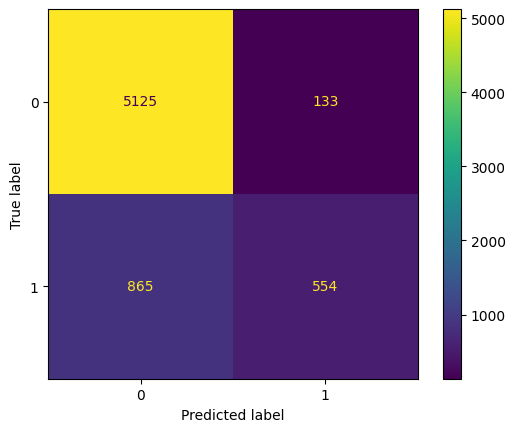

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      5258
           1       0.81      0.39      0.53      1419

    accuracy                           0.85      6677
   macro avg       0.83      0.68      0.72      6677
weighted avg       0.85      0.85      0.83      6677



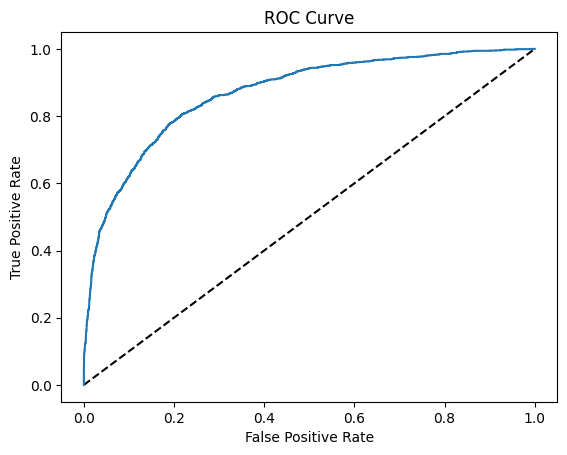

AUROC XGB H1N1 Train: 0.8973424981517037
AUROC XGB H1N1 Test: 0.8686736892217798


In [66]:
# Display Confusion Matrix
conf_matrix_plot(rf_h1n1_opt, X_test, y_test)

# Classification Report (H1N1)
print(classification_report(y_test, y_preds_test_h1n1_opt))

# Seasonal Test
draw_roc_curve(y_test, y_pred_proba_test_h1n1_opt[:,1])

# Calculate ROC AUC score for RF
roc_auc_train_rf_h1n1_opt = roc_auc_score(y_train, y_pred_proba_train_h1n1_opt[:,1])
roc_auc_test_rf_h1n1_opt = roc_auc_score(y_test, y_pred_proba_test_h1n1_opt[:,1])

# Print ROC AUC scores
print(f'AUROC XGB H1N1 Train: {roc_auc_train_rf_h1n1_opt}'
      f'\nAUROC XGB H1N1 Test: {roc_auc_test_rf_h1n1_opt}'
)

In [67]:
# Seasonal w/ Optuna
rf_se_opt = RandomForestClassifier(**study_se.best_params)

# Fit the model on the entire training set
rf_se_opt.fit(X_train_se, y_train_se)

# Predict probabilities for the TRAIN set
y_pred_proba_train_se_opt = rf_se_opt.predict_proba(X_train_se)

# Predict probabilities for the TEST set
y_pred_proba_test_se_opt = rf_se_opt.predict_proba(X_test_se)

# Predict scores for TEST set
y_preds_test_se_opt = rf_se_opt.predict(X_test_se)

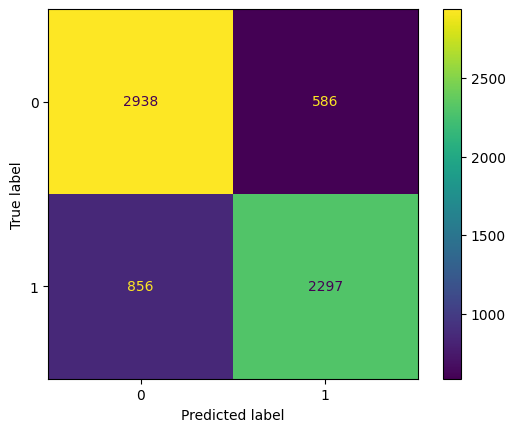

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3524
           1       0.80      0.73      0.76      3153

    accuracy                           0.78      6677
   macro avg       0.79      0.78      0.78      6677
weighted avg       0.78      0.78      0.78      6677



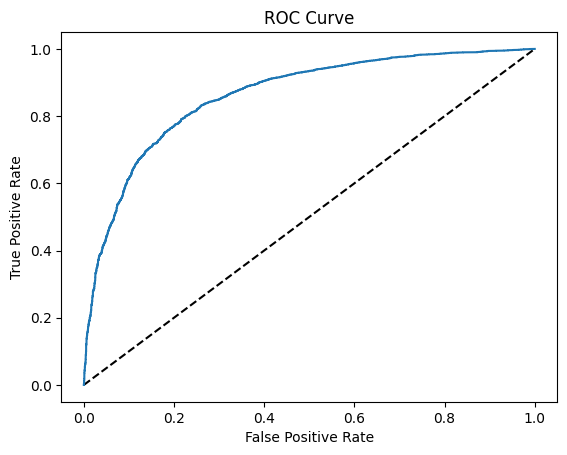

AUROC RF Seasonal Train: 0.8794407273659226
AUROC RF Seasonal Test: 0.8612876301437867


In [68]:
# Display Confusion Matrix
conf_matrix_plot(rf_se_opt, X_test_se, y_test_se)

# Classification Report (Seasonal)
print(classification_report(y_test_se, y_preds_test_se_opt))

# Seasonal Test
draw_roc_curve(y_test_se, y_pred_proba_test_se_opt[:,1])

# Calculate ROC AUC score for RF
roc_auc_train_rf_se_opt = roc_auc_score(y_train_se, y_pred_proba_train_se_opt[:,1])
roc_auc_test_rf_se_opt = roc_auc_score(y_test_se, y_pred_proba_test_se_opt[:,1])

# Print ROC AUC scores
print(f'AUROC RF Seasonal Train: {roc_auc_train_rf_se_opt}'
      f'\nAUROC RF Seasonal Test: {roc_auc_test_rf_se_opt}'
)

## Predict on Unseen Data

In [69]:
# Join test_set_feat and train_set_lab by 'respondent_id' column
test_data = test_set_feat

test_data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,35 - 44 Years,College Graduate,Hispanic,Female,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,1.0,1.0,18 - 34 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,4.0,2.0,5.0,4.0,4.0,55 - 64 Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,2.0,4.0,4.0,2.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,2.0,4.0,4.0,4.0,2.0,35 - 44 Years,12 Years,Black,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [70]:
# Use function to transform test set data
test_data_encoded = data_encoding(test_data)

In [71]:
# Additional Step for Random Forest
# One Hot Encode columns with missing values
test_data_reencoded = pd.get_dummies(test_data_encoded, columns=test_data_encoded.columns[test_data_encoded.isna().any()], dummy_na=True)

test_data_reencoded.shape

(26708, 176)

In [72]:
%%time

# Fit on Entire Training Dataset (H1N1)
rf_h1n1_opt.fit(X, y)

# Fit on Entire Training Dataset (Seasonal)
rf_se_opt.fit(X_se, y_se)

CPU times: user 4.99 s, sys: 4.75 ms, total: 5 s
Wall time: 4.99 s


RandomForestClassifier(max_depth=10, max_features='auto',
                       max_samples=0.7675965669381748, min_samples_split=32,
                       n_estimators=136)

In [73]:
# Predict probabilities for the unseen data (H1N1)
y_test_data_pred_proba_rf_h1n1 = rf_h1n1_opt.predict_proba(test_data_reencoded)
print(y_test_data_pred_proba_rf_h1n1[:,1])

# Predict probabilities for the unseen data (Seasonal)
y_test_data_pred_proba_rf_se = rf_se_opt.predict_proba(test_data_reencoded)
print(y_test_data_pred_proba_rf_se[:,1])


[0.18856845 0.04056125 0.21991637 ... 0.14267067 0.07018189 0.50426512]
[0.25410688 0.07697639 0.67937597 ... 0.265371   0.31645577 0.55762964]


## Export to CSV

In [74]:
# Insert columns into 'submission'
submission['h1n1_vaccine'] = y_test_data_pred_proba_rf_h1n1[:,1]
submission['seasonal_vaccine'] = y_test_data_pred_proba_rf_se[:,1]

submission.to_csv('Submission_Files/submission_rf.csv', index=False)

In [75]:
submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.188568,0.254107
1,26708,0.040561,0.076976
2,26709,0.219916,0.679376
3,26710,0.554711,0.792090
4,26711,0.350836,0.509149
...,...,...,...
26703,53410,0.294001,0.493026
26704,53411,0.172883,0.437411
26705,53412,0.142671,0.265371
26706,53413,0.070182,0.316456
